In [1]:
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib monai

Note: you may need to restart the kernel to use updated packages.


In [3]:
import multiprocessing
import json

import matplotlib.pyplot as plt

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    RandSpatialCropSamplesd, Transposed, ToTensord
)

from monai.data import Dataset
import torch
from torch.utils.data import DataLoader

In [4]:
print(f'There are {multiprocessing.cpu_count()} CPU cores available.')
print(f'PyTorch version: {torch.__version__}.')
print(f'CUDA GPU available: {torch.cuda.is_available()}.')
print(f'Mac MPS Backend available: {torch.mps.is_available()}.')

There are 10 CPU cores available.
PyTorch version: 2.8.0.dev20250530.
CUDA GPU available: False.
Mac MPS Backend available: True.


In [5]:
CT_Transforms = Compose([
    LoadImaged(keys=['Image', 'Label']),
    ScaleIntensityRanged(
        keys=['Image'],
        a_min=-150, a_max=250,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    Transposed(keys=["Image", "Label"], indices=(2, 0, 1)),  # (H, W, D) → (D, H, W)
    EnsureChannelFirstd(keys=['Image', 'Label']),
    RandSpatialCropSamplesd(
        keys=['Image', 'Label'],
        roi_size=(32, 32, 32),
        num_samples=4
    ),
    ToTensord(keys=['Image', 'Label'])
])

In [6]:
with open('Data/segmentation_filepaths.json') as f:
    data_dict = json.load(f)

data_list = data_dict["Segmentation"]

dataset = Dataset(data=data_list, transform=CT_Transforms)
#loader = DataLoader(
#    dataset,
#    batch_size=2,           # safe number for 3D scans
#    shuffle=True,
#    num_workers=6,          # leverage M4 Pro cores
#    pin_memory=False        # not needed on macOS
#)

In [7]:
print(f"There are {len(dataset)} scan-label sets in total (each with multiple patches).")

patches = dataset[0]  # list of dictionaries, e.g., 4 patches
print(f"Scan 0 contains {len(patches)} patches.")

for i, patch in enumerate(patches):
    scan = patch["Image"]
    label = patch["Label"]

    print(f"\n📦 Patch {i + 1}")
    print(f"Scan Min, Max: {scan.min():.3f}, {scan.max():.3f}")
    print(f"Label Min, Max: {label.min()}, {label.max()}")
    print(f"Scan Shape: {scan.shape}, Label Shape: {label.shape}")

There are 500 scan-label sets in total (each with multiple patches).
Scan 0 contains 4 patches.

📦 Patch 1
Scan Min, Max: 0.000, 0.000
Label Min, Max: 0.0, 0.0
Scan Shape: torch.Size([1, 32, 32, 32]), Label Shape: torch.Size([1, 32, 32, 32])

📦 Patch 2
Scan Min, Max: 0.000, 0.525
Label Min, Max: 0.0, 0.0
Scan Shape: torch.Size([1, 32, 32, 32]), Label Shape: torch.Size([1, 32, 32, 32])

📦 Patch 3
Scan Min, Max: 0.000, 1.000
Label Min, Max: 0.0, 1.0
Scan Shape: torch.Size([1, 32, 32, 32]), Label Shape: torch.Size([1, 32, 32, 32])

📦 Patch 4
Scan Min, Max: 0.000, 0.310
Label Min, Max: 0.0, 0.0
Scan Shape: torch.Size([1, 32, 32, 32]), Label Shape: torch.Size([1, 32, 32, 32])


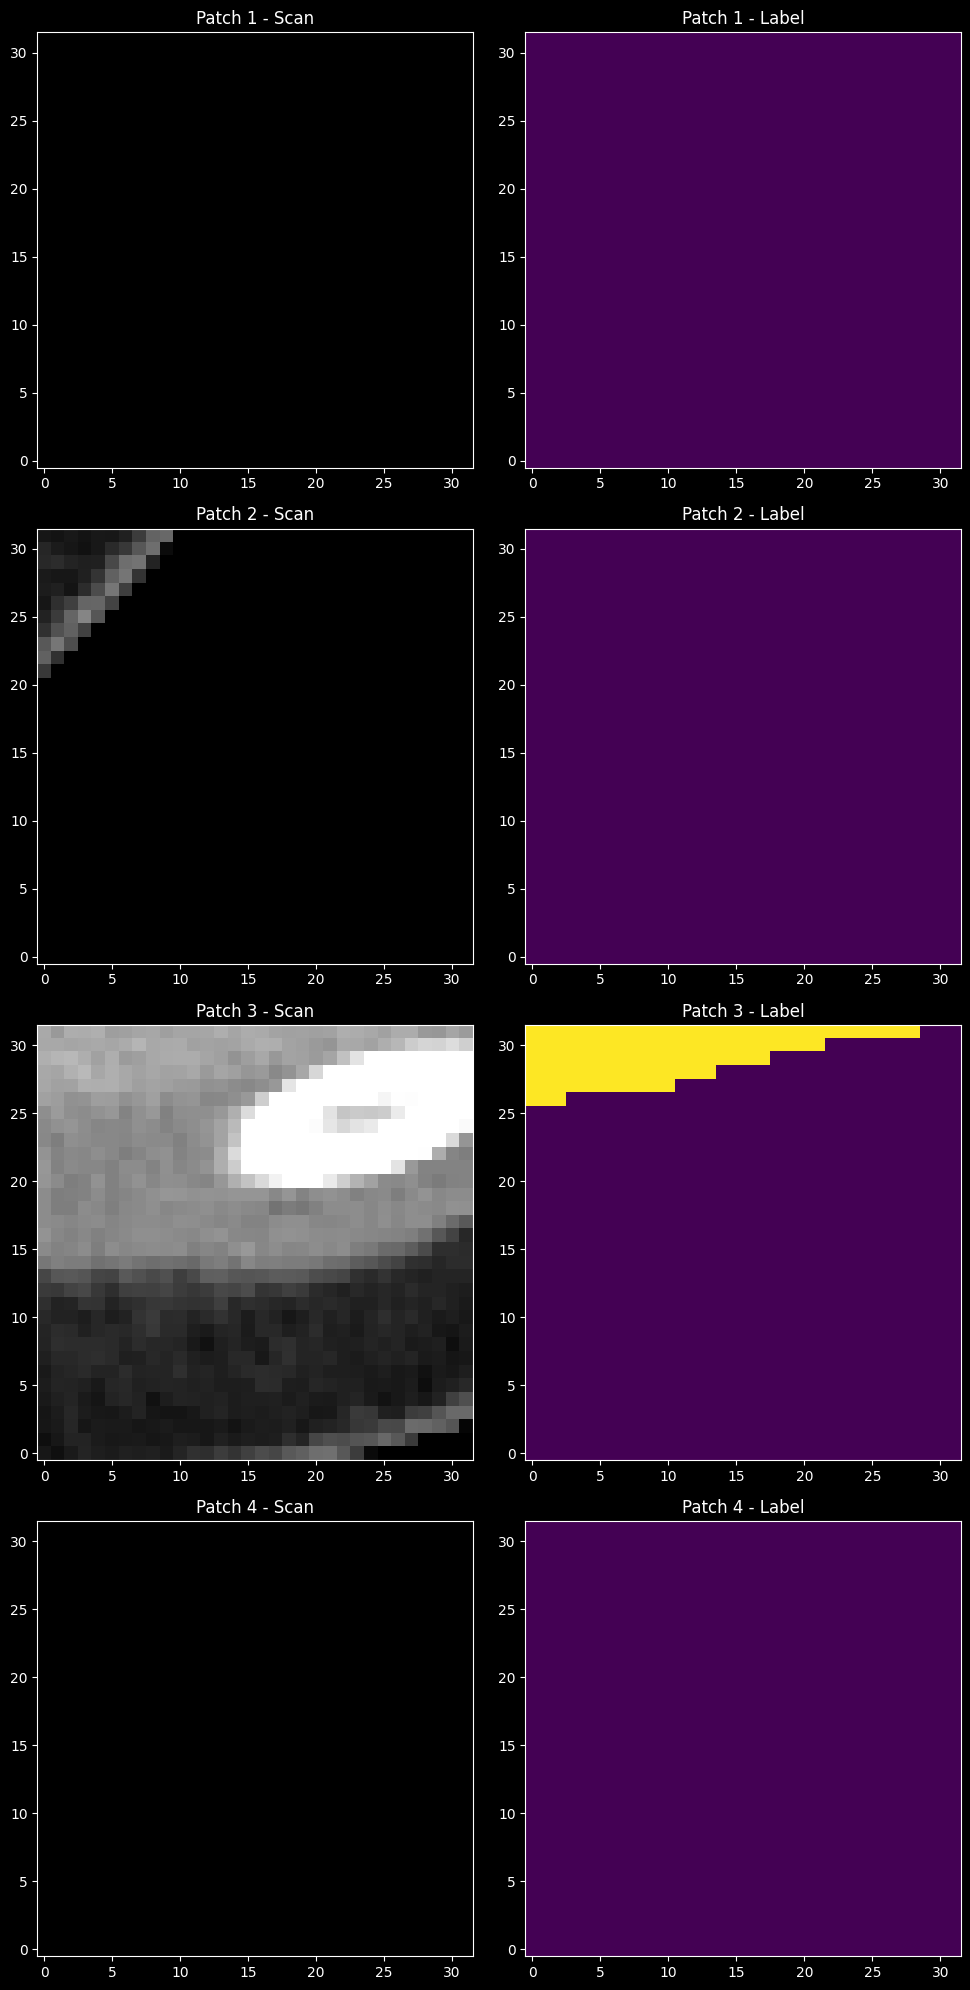

In [8]:
text_color = 'white'
bg_color = 'black'

num_patches = len(patches)

fig, axes = plt.subplots(num_patches, 2, figsize=(10, 5 * num_patches))
fig.patch.set_facecolor(bg_color)

if num_patches == 1:
    axes = [axes]  # ensure axes is 2D even for 1 patch

for i, patch in enumerate(patches):
    scan = patch["Image"]
    label = patch["Label"]

    # Take center depth slice
    depth = scan.shape[1] // 2
    scan_slice = scan[0].detach().cpu().numpy()[depth]
    label_slice = label[0].detach().cpu().numpy()[depth]

    ax_scan = axes[i][0]
    ax_label = axes[i][1]

    # Set dark background and tick colors
    for ax in [ax_scan, ax_label]:
        ax.set_facecolor(bg_color)
        ax.spines['top'].set_color(text_color)
        ax.spines['bottom'].set_color(text_color)
        ax.spines['left'].set_color(text_color)
        ax.spines['right'].set_color(text_color)
        ax.tick_params(axis='x', colors=text_color)
        ax.tick_params(axis='y', colors=text_color)

    ax_scan.imshow(scan_slice, cmap='gray', origin='lower', vmin=0, vmax=1)
    ax_scan.set_title(f"Patch {i+1} - Scan", color=text_color)

    ax_label.imshow(label_slice, origin='lower')
    ax_label.set_title(f"Patch {i+1} - Label", color=text_color)

plt.tight_layout()
plt.show()